In [3]:
from pathlib import Path
import pandas as pd
from glob import glob

# === STEP 1: point to your data folder ===
DATA_DIR = Path("../kalshi_fetcher/data/enriched_trades")  # change if your folder lives elsewhere

# Find CSVs
files = sorted(DATA_DIR.glob("*.csv"))
print(f"Found {len(files)} CSVs in {DATA_DIR.resolve()}")

# Preview a few filenames
for f in files[:5]:
    print(" -", f.name)

# Peek at the first file's columns (if any files exist)
if files:
    try:
        preview = pd.read_csv(files[0], nrows=3)
        print("\nFirst file:", files[0].name)
        print("Columns:", list(preview.columns))
        display(preview)
    except Exception as e:
        print("Could not read first file:", e)


Found 5000 CSVs in C:\Users\Adam Nhan\prediction-market-money-printer\kalshi_fetcher\data\enriched_trades
 - KXBTC-25NOV0417-B100250.csv
 - KXBTC-25NOV0417-B100750.csv
 - KXBTC-25NOV0417-B101250.csv
 - KXBTC-25NOV0417-B101750.csv
 - KXBTC-25NOV0417-B102250.csv

First file: KXBTC-25NOV0417-B100250.csv
Columns: ['ticker', 'created_time', 'price', 'count', 'taker_side', 'trade_id', 'event_ticker', 'category', 'event_time', 'created_time_dt', 'event_time_dt', 'seconds_before_event', 'minutes_before_event']


,ticker,created_time,price,count,taker_side,trade_id,event_ticker,category,event_time,created_time_dt,event_time_dt,seconds_before_event,minutes_before_event
0,KXBTC-25NOV0417-B100250,2025-11-04T21:59:45.110675Z,0.99,78,yes,9d5254fe-5ca6-6799-70de-1e6039414fd7,KXBTC-25NOV0417,Crypto,2025-11-04T22:00:00Z,2025-11-04 21:59:45.110675+00:00,2025-11-04 22:00:00+00:00,14.889325,0.248155
1,KXBTC-25NOV0417-B100250,2025-11-04T21:59:37.47891Z,0.96,11,yes,8fc5b092-efd8-6445-245c-ce3810a0d3da,KXBTC-25NOV0417,Crypto,2025-11-04T22:00:00Z,2025-11-04 21:59:37.478910+00:00,2025-11-04 22:00:00+00:00,22.521090,0.375352
2,KXBTC-25NOV0417-B100250,2025-11-04T21:59:37.428489Z,0.96,4,no,d1832418-34b7-4840-92bc-61173ed7c742,KXBTC-25NOV0417,Crypto,2025-11-04T22:00:00Z,2025-11-04 21:59:37.428489+00:00,2025-11-04 22:00:00+00:00,22.571511,0.376192


Rows: 68
                     ticker                 created_time  price  count  \
67  KXBTC-25NOV0417-B100250  2025-11-04T13:59:46.944365Z   0.05      1   
66  KXBTC-25NOV0417-B100250    2025-11-04T13:59:47.9374Z   0.05      1   
65  KXBTC-25NOV0417-B100250  2025-11-04T13:59:49.959349Z   0.05      1   
64  KXBTC-25NOV0417-B100250  2025-11-04T13:59:54.483396Z   0.02      1   
63  KXBTC-25NOV0417-B100250  2025-11-04T15:51:31.498062Z   0.07      1   

   taker_side                              trade_id     event_ticker category  \
67        yes  8b45d997-2946-41fa-f996-1f532f8f01ad  KXBTC-25NOV0417   Crypto   
66        yes  526ec7d4-e886-402e-d088-79b8f6984ce9  KXBTC-25NOV0417   Crypto   
65        yes  d040fbf8-5c4e-6c72-92c2-1f0102d79dd9  KXBTC-25NOV0417   Crypto   
64         no  2dfe9a34-d635-4ab4-868f-d506a5212e6d  KXBTC-25NOV0417   Crypto   
63         no  1834c9ab-4bbe-444a-8571-fbcc4a2ce787  KXBTC-25NOV0417   Crypto   

              event_time                  created_time_dt  

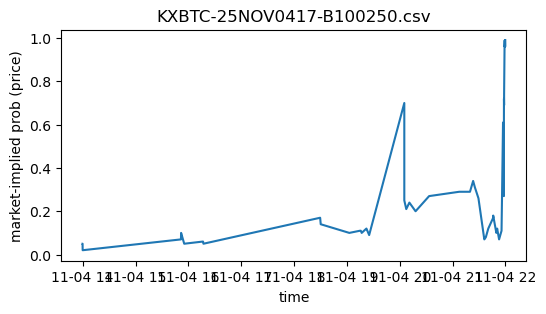

In [4]:
import matplotlib.pyplot as plt

# === STEP 2: load one file and inspect probability ===
sample_path = files[0]
df = pd.read_csv(sample_path)

# We'll treat the trade "price" column as the implied probability of YES
df["created_time_dt"] = pd.to_datetime(df["created_time_dt"], errors="coerce", utc=True)
df = df.sort_values("created_time_dt")

print("Rows:", len(df))
print(df.head())

# Quick plot of price over time
plt.figure(figsize=(6,3))
plt.plot(df["created_time_dt"], df["price"])
plt.title(sample_path.name)
plt.xlabel("time")
plt.ylabel("market-implied prob (price)")
plt.show()


In [5]:
# === STEP 3: define minimal backtest for one market ===
def simulate_yes_trade(df, entry_threshold=0.75, payoff_yes=1.0):
    """
    Enter YES once price >= entry_threshold.
    Hold until settlement (payoff_yes is 1 if YES wins, 0 if NO wins).
    Return entry_price, pnl.
    """
    # ensure sorted
    df = df.sort_values("created_time_dt")
    # first time we cross threshold
    crossed = df[df["price"] >= entry_threshold]
    if crossed.empty:
        return None, 0.0  # no trade
    
    entry_price = crossed["price"].iloc[0]
    pnl = payoff_yes - entry_price
    return entry_price, pnl

# quick test on your sample file
entry_price, pnl = simulate_yes_trade(df)
print(f"Entry price: {entry_price},  PnL if YES wins: {pnl:.4f}")


Entry price: 0.96,  PnL if YES wins: 0.0400


In [8]:
from pathlib import Path
import pandas as pd

# === STEP 5 (fixed): load closed_markets.csv using full path ===
results_path = Path(r"C:\Users\Adam Nhan\prediction-market-money-printer\data\closed_markets.csv")
results_df = pd.read_csv(results_path)

print("Loaded:", results_path)
print("Rows:", len(results_df))
print("Columns:", list(results_df.columns))
display(results_df.head(5))

# Build mapping: ticker -> result (1 if YES, 0 if NO)
result_map = {}
for _, row in results_df.iterrows():
    t = str(row.get("ticker") or row.get("event_ticker"))
    res = str(row.get("result")).strip().lower() if pd.notna(row.get("result")) else None
    if res in ["yes", "y", "1", "true"]:
        result_map[t] = 1.0
    elif res in ["no", "n", "0", "false"]:
        result_map[t] = 0.0

print(f"Built result_map with {len(result_map)} tickers.")
list(result_map.items())[:5]



Loaded: C:\Users\Adam Nhan\prediction-market-money-printer\data\closed_markets.csv
Rows: 5000
Columns: ['ticker', 'event_ticker', 'category', 'normalized_status', 'status', 'close_time', 'volume', 'last_price', 'result', 'settlement_value']


,ticker,event_ticker,category,normalized_status,status,close_time,volume,last_price,result,settlement_value
0,KXETHD-25NOV1212-T3489.99,KXETHD-25NOV1212,Crypto,settled,finalized,2025-11-12T17:00:00Z,1340,9,no,0
1,KXETHD-25NOV1212-T3469.99,KXETHD-25NOV1212,Crypto,settled,finalized,2025-11-12T17:00:00Z,5735,17,no,0
2,KXETHD-25NOV1212-T3449.99,KXETHD-25NOV1212,Crypto,settled,finalized,2025-11-12T17:00:00Z,6537,6,no,0
3,KXETHD-25NOV1212-T3429.99,KXETHD-25NOV1212,Crypto,settled,finalized,2025-11-12T17:00:00Z,26099,1,no,0
4,KXETHD-25NOV1212-T3409.99,KXETHD-25NOV1212,Crypto,settled,finalized,2025-11-12T17:00:00Z,60734,31,no,0


Built result_map with 5000 tickers.


[('KXETHD-25NOV1212-T3489.99', 0.0),
 ('KXETHD-25NOV1212-T3469.99', 0.0),
 ('KXETHD-25NOV1212-T3449.99', 0.0),
 ('KXETHD-25NOV1212-T3429.99', 0.0),
 ('KXETHD-25NOV1212-T3409.99', 0.0)]

In [10]:
import numpy as np
from tqdm import tqdm

# === STEP 6: backtest across all markets ===
ENTRY_THRESHOLD = 0.75

trades = []

for fp in tqdm(files[:]):  # you can change [:] to [:100] first for speed
    try:
        df = pd.read_csv(fp)
    except Exception as e:
        continue

    if "price" not in df.columns:
        continue

    df["created_time_dt"] = pd.to_datetime(df["created_time_dt"], errors="coerce", utc=True)
    df = df.sort_values("created_time_dt")

    crossed = df[df["price"] >= ENTRY_THRESHOLD]
    if crossed.empty:
        continue

    entry_price = crossed["price"].iloc[0]
    ticker = str(df["ticker"].iloc[0])
    payoff_yes = result_map.get(ticker)
    if payoff_yes is None:
        continue  # skip if we don't have an outcome

    pnl = payoff_yes - entry_price
    trades.append({
        "ticker": ticker,
        "entry_price": entry_price,
        "payoff_yes": payoff_yes,
        "pnl": pnl
    })

bt = pd.DataFrame(trades)
print("Total trades:", len(bt))
bt.head()


100%|██████████| 5000/5000 [00:12<00:00, 397.88it/s]

Total trades: 1926


,ticker,entry_price,payoff_yes,pnl
0,KXBTC-25NOV0417-B100250,0.96,1.0,0.04
1,KXBTC-25NOV0509-B102875,0.76,1.0,0.24
2,KXBTC-25NOV0510-B103125,0.96,1.0,0.04
3,KXBTC-25NOV0510-B103625,0.96,0.0,-0.96
4,KXBTC-25NOV0511-B103625,0.81,1.0,0.19


In [11]:
# === STEP 7: summarize performance (with optional fees) ===

FEE_ENTRY = 0.00      # e.g., 0.01 for 1¢ fee to open
FEE_SETTLE = 0.00     # e.g., 0.00–0.01 depending on venue
bt = bt.copy()
bt["fees"] = FEE_ENTRY + FEE_SETTLE
bt["pnl_net"] = bt["pnl"] - bt["fees"]

# Basic QC
dups = bt["ticker"].duplicated().sum()
print(f"QC: duplicate trades on same ticker: {dups}")

# Headline metrics
total_trades = len(bt)
total_pnl_net = bt["pnl_net"].sum()
avg_pnl_net = bt["pnl_net"].mean()
hit_rate = (bt["payoff_yes"] == 1.0).mean()              # how often YES actually won
win_rate = (bt["pnl_net"] > 0).mean()                    # how often trade made money
p95 = bt["pnl_net"].quantile(0.95)
p05 = bt["pnl_net"].quantile(0.05)

print("\nCrowd YES when p ≥ 0.75 (hold to settlement)")
print(f"Total trades:        {total_trades}")
print(f"Total PnL (net):     {total_pnl_net:.3f}")
print(f"Avg PnL per trade:   {avg_pnl_net:.4f}")
print(f"Hit rate (YES wins): {hit_rate:.3f}")
print(f"Win rate (PnL>0):    {win_rate:.3f}")
print(f"P95 / P05 PnL:       {p95:.3f} / {p05:.3f}")

# Quick glance at extremes
display(bt.nsmallest(5, "pnl_net"))
display(bt.nlargest(5, "pnl_net"))


QC: duplicate trades on same ticker: 0

Crowd YES when p ≥ 0.75 (hold to settlement)
Total trades:        1926
Total PnL (net):     -69.690
Avg PnL per trade:   -0.0362
Hit rate (YES wins): 0.828
Win rate (PnL>0):    0.828
P95 / P05 PnL:       0.250 / -0.850


,ticker,entry_price,payoff_yes,pnl,fees,pnl_net
50,KXBTC-25NOV0715-B103125,0.99,0.0,-0.99,0.0,-0.99
695,KXBTCD-25NOV0815-T102499.99,0.99,0.0,-0.99,0.0,-0.99
1254,KXETH-25NOV0718-B3460,0.99,0.0,-0.99,0.0,-0.99
1274,KXETH-25NOV0915-B3590,0.99,0.0,-0.99,0.0,-0.99
1278,KXETH-25NOV0921-B3650,0.99,0.0,-0.99,0.0,-0.99


,ticker,entry_price,payoff_yes,pnl,fees,pnl_net
6,KXBTC-25NOV0513-B103875,0.75,1.0,0.25,0.0,0.25
8,KXBTC-25NOV0515-B104125,0.75,1.0,0.25,0.0,0.25
9,KXBTC-25NOV0516-B103875,0.75,1.0,0.25,0.0,0.25
10,KXBTC-25NOV0517-B103750,0.75,1.0,0.25,0.0,0.25
49,KXBTC-25NOV0714-B102625,0.75,1.0,0.25,0.0,0.25


In [12]:
import pandas as pd
import numpy as np

def ensure_min_before_event(df):
    """Return a copy with a 'minutes_before_event' column."""
    df = df.copy()
    if "minutes_before_event" in df.columns and df["minutes_before_event"].notna().any():
        return df

    # try to compute from timestamps
    for col in ["created_time_dt", "created_time"]:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors="coerce", utc=True)
    for col in ["event_time_dt", "event_time"]:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors="coerce", utc=True)

    ct = df.get("created_time_dt", df.get("created_time"))
    et = df.get("event_time_dt", df.get("event_time"))
    if ct is None or et is None:
        df["minutes_before_event"] = np.nan
        return df

    delta = (et - ct).dt.total_seconds() / 60.0
    df["minutes_before_event"] = delta
    return df

# quick check on one file already loaded as df
df_qc = ensure_min_before_event(df)
print("minutes_before_event present:", "minutes_before_event" in df_qc.columns)
print(df_qc[["created_time_dt","event_time_dt","minutes_before_event"]].head())


minutes_before_event present: True
                   created_time_dt              event_time_dt  \
0 2025-11-12 14:23:17.839438+00:00  2025-11-12 15:00:00+00:00   

   minutes_before_event  
0             36.702676  


In [15]:
from tqdm import tqdm
import numpy as np
import pandas as pd

ENTRY_THRESHOLD = 0.85
TIME_LIMIT_MINUTES = 5

trades_last5 = []

for fp in tqdm(files[:]):  # you can test with [:100] first
    try:
        df = pd.read_csv(fp)
    except Exception:
        continue

    if "price" not in df.columns:
        continue

    df = ensure_min_before_event(df)
    df["created_time_dt"] = pd.to_datetime(df["created_time_dt"], errors="coerce", utc=True)
    df = df.sort_values("created_time_dt")

    # restrict to last 5 minutes before event
    recent = df[df["minutes_before_event"] <= TIME_LIMIT_MINUTES]
    if recent.empty:
        continue

    crossed = recent[recent["price"] >= ENTRY_THRESHOLD]
    if crossed.empty:
        continue

    entry_price = crossed["price"].iloc[0]
    ticker = str(df["ticker"].iloc[0])
    payoff_yes = result_map.get(ticker)
    if payoff_yes is None:
        continue

    pnl = payoff_yes - entry_price
    trades_last5.append({
        "ticker": ticker,
        "entry_price": entry_price,
        "payoff_yes": payoff_yes,
        "pnl": pnl
    })

bt5 = pd.DataFrame(trades_last5)
print("Total trades (last 5 min rule):", len(bt5))
bt5.head()


100%|██████████| 5000/5000 [00:15<00:00, 332.20it/s]

Total trades (last 5 min rule): 641


,ticker,entry_price,payoff_yes,pnl
0,KXBTC-25NOV0417-B100250,0.96,1.0,0.04
1,KXBTC-25NOV0509-B102875,0.96,1.0,0.04
2,KXBTC-25NOV0510-B103125,0.96,1.0,0.04
3,KXBTC-25NOV0510-B103625,0.96,0.0,-0.96
4,KXBTC-25NOV0511-B103625,0.94,1.0,0.06


In [16]:
# === STEP 10: summarize the last-5-min strategy (with optional fees) ===

FEE_ENTRY = 0.00    # e.g., 0.01 per contract to open
FEE_SETTLE = 0.00   # e.g., 0.00–0.01 per contract at settlement

bt5 = bt5.copy()
bt5["fees"] = FEE_ENTRY + FEE_SETTLE
bt5["pnl_net"] = bt5["pnl"] - bt5["fees"]

total_trades   = len(bt5)
total_pnl_net  = bt5["pnl_net"].sum()
avg_pnl_net    = bt5["pnl_net"].mean()
hit_rate       = (bt5["payoff_yes"] == 1.0).mean()
win_rate       = (bt5["pnl_net"] > 0).mean()
p95            = bt5["pnl_net"].quantile(0.95)
p05            = bt5["pnl_net"].quantile(0.05)

print("Crowd YES when p ≥ 0.85, only in last 5 minutes (hold to settlement)")
print(f"Total trades:        {total_trades}")
print(f"Total PnL (net):     {total_pnl_net:.3f}")
print(f"Avg PnL per trade:   {avg_pnl_net:.4f}")
print(f"Hit rate (YES wins): {hit_rate:.3f}")
print(f"Win rate (PnL>0):    {win_rate:.3f}")
print(f"P95 / P05 PnL:       {p95:.3f} / {p05:.3f}")

# Extremes
print("\nWorst 5 trades:")
display(bt5.nsmallest(5, "pnl_net"))
print("\nBest 5 trades:")
display(bt5.nlargest(5, "pnl_net"))


Crowd YES when p ≥ 0.85, only in last 5 minutes (hold to settlement)
Total trades:        641
Total PnL (net):     -17.960
Avg PnL per trade:   -0.0280
Hit rate (YES wins): 0.913
Win rate (PnL>0):    0.913
P95 / P05 PnL:       0.150 / -0.930

Worst 5 trades:


,ticker,entry_price,payoff_yes,pnl,fees,pnl_net
489,KXETH-25NOV0621-B3310,0.98,0.0,-0.98,0.0,-0.98
516,KXETH-25NOV1116-B3450,0.98,0.0,-0.98,0.0,-0.98
592,KXETHD-25NOV0822-T3369.99,0.98,0.0,-0.98,0.0,-0.98
482,KXETH-25NOV0612-B3290,0.97,0.0,-0.97,0.0,-0.97
486,KXETH-25NOV0616-B3290,0.97,0.0,-0.97,0.0,-0.97



Best 5 trades:


,ticker,entry_price,payoff_yes,pnl,fees,pnl_net
5,KXBTC-25NOV0512-B103875,0.85,1.0,0.15,0.0,0.15
14,KXBTC-25NOV0520-B103625,0.85,1.0,0.15,0.0,0.15
43,KXBTC-25NOV0713-B102375,0.85,1.0,0.15,0.0,0.15
109,KXBTC-25NOV1015-B105875,0.85,1.0,0.15,0.0,0.15
117,KXBTC-25NOV1020-B106125,0.85,1.0,0.15,0.0,0.15


In [17]:
from tqdm import tqdm
import pandas as pd
import numpy as np

ENTRY_YES = 0.75
ENTRY_NO  = 0.25
TIME_LIMIT_MINUTES = 5
FEE_ENTRY = 0.00
FEE_SETTLE = 0.00

rows = []

for fp in tqdm(files[:]):  # use [:100] to test quickly
    try:
        df = pd.read_csv(fp)
    except Exception:
        continue
    if "price" not in df.columns or df.empty:
        continue

    df = ensure_min_before_event(df)
    df["created_time_dt"] = pd.to_datetime(df["created_time_dt"], errors="coerce", utc=True)
    df = df.sort_values("created_time_dt")

    recent = df[df["minutes_before_event"] <= TIME_LIMIT_MINUTES]
    if recent.empty:
        continue

    # first trigger within last 5 minutes (either YES or NO)
    triggers = recent[(recent["price"] >= ENTRY_YES) | (recent["price"] <= ENTRY_NO)]
    if triggers.empty:
        continue

    entry = triggers.iloc[0]
    price_yes = float(entry["price"])
    side = "YES" if price_yes >= ENTRY_YES else "NO"

    ticker = str(df["ticker"].iloc[0])
    payoff_yes = result_map.get(ticker)
    if payoff_yes is None:
        continue

    # PnL if held to settlement
    if side == "YES":
        pnl_gross = payoff_yes - price_yes
        hit = float(payoff_yes)
    else:  # side == "NO", assume NO price = 1 - price_yes
        pnl_gross = (1.0 - payoff_yes) - (1.0 - price_yes)  # == price_yes - payoff_yes
        hit = float(1.0 - payoff_yes)

    fees = FEE_ENTRY + FEE_SETTLE
    pnl_net = pnl_gross - fees

    rows.append({
        "ticker": ticker,
        "side": side,
        "entry_price_yes": price_yes,
        "payoff_yes": float(payoff_yes),
        "minutes_before_event": float(entry.get("minutes_before_event", np.nan)),
        "fees": fees,
        "pnl": pnl_gross,
        "pnl_net": pnl_net,
    })

bt_both = pd.DataFrame(rows)
print("Total trades (last 5 min, YES≥0.75 or NO≤0.25):", len(bt_both))
bt_both.head()


100%|██████████| 5000/5000 [00:13<00:00, 366.27it/s]

Total trades (last 5 min, YES≥0.75 or NO≤0.25): 1359


,ticker,side,entry_price_yes,payoff_yes,minutes_before_event,fees,pnl,pnl_net
0,KXBTC-25NOV0417-B100250,NO,0.11,1.0,4.479511,0.0,-0.89,-0.89
1,KXBTC-25NOV0417-B111750,NO,0.01,0.0,1.788226,0.0,0.01,0.01
2,KXBTC-25NOV0417-B112250,NO,0.01,0.0,1.788171,0.0,0.01,0.01
3,KXBTC-25NOV0417-B112750,NO,0.01,0.0,1.788224,0.0,0.01,0.01
4,KXBTC-25NOV0417-B113250,NO,0.01,0.0,1.788160,0.0,0.01,0.01


In [18]:
# Summary
tot = len(bt_both)
by_side = bt_both["side"].value_counts().to_dict()
total_pnl = bt_both["pnl_net"].sum()
avg_pnl   = bt_both["pnl_net"].mean()
win_rate  = (bt_both["pnl_net"] > 0).mean()

# side-specific hit rates
yes_hit = bt_both.loc[bt_both["side"]=="YES", "payoff_yes"].mean() if "YES" in by_side else np.nan
no_hit  = (1.0 - bt_both.loc[bt_both["side"]=="NO", "payoff_yes"]).mean() if "NO" in by_side else np.nan

print("Symmetric last-5-min rule (YES≥0.75 or NO≤0.25, hold to settlement)")
print(f"Total trades:      {tot}  |  Split: {by_side}")
print(f"Total PnL (net):   {total_pnl:.3f}")
print(f"Avg PnL per trade: {avg_pnl:.4f}")
print(f"Win rate (PnL>0):  {win_rate:.3f}")
print(f"YES hit rate:      {yes_hit:.3f}")
print(f"NO  hit rate:      {no_hit:.3f}")

# distribution by entry price buckets
bt_both["bucket"] = pd.cut(bt_both["entry_price_yes"], [0.0,0.25,0.50,0.75,1.00], right=False)
display(bt_both.groupby(["side","bucket"])["pnl_net"].agg(['size','mean','sum']).reset_index())

# peek at extremes
display(bt_both.nsmallest(5, "pnl_net"))
display(bt_both.nlargest(5, "pnl_net"))


Symmetric last-5-min rule (YES≥0.75 or NO≤0.25, hold to settlement)
Total trades:      1359  |  Split: {'NO': 745, 'YES': 614}
Total PnL (net):   -6.130
Avg PnL per trade: -0.0045
Win rate (PnL>0):  0.914
YES hit rate:      0.904
NO  hit rate:      0.922


C:\Users\Adam Nhan\AppData\Local\Temp\ipykernel_24836\375324261.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(bt_both.groupby(["side","bucket"])["pnl_net"].agg(['size','mean','sum']).reset_index())


,side,bucket,size,mean,sum
0,NO,"[0.0, 0.25)",713,-0.001360,-0.97
1,NO,"[0.25, 0.5)",32,0.000000,0.00
2,NO,"[0.5, 0.75)",0,NaN,0.00
3,NO,"[0.75, 1.0)",0,NaN,0.00
4,YES,"[0.0, 0.25)",0,NaN,0.00
5,YES,"[0.25, 0.5)",0,NaN,0.00
6,YES,"[0.5, 0.75)",0,NaN,0.00
7,YES,"[0.75, 1.0)",614,-0.008404,-5.16


,ticker,side,entry_price_yes,payoff_yes,minutes_before_event,fees,pnl,pnl_net,bucket
857,KXBTCD-25NOV1020-T105999.99,NO,0.01,1.0,4.963154,0.0,-0.99,-0.99,"[0.0, 0.25)"
883,KXBTCD-25NOV1110-T104499.99,NO,0.01,1.0,3.731019,0.0,-0.99,-0.99,"[0.0, 0.25)"
1068,KXETH-25NOV0621-B3310,YES,0.98,0.0,2.097284,0.0,-0.98,-0.98,"[0.75, 1.0)"
1136,KXETHD-25NOV0417-T3179.99,NO,0.02,1.0,4.940681,0.0,-0.98,-0.98,"[0.0, 0.25)"
1258,KXETHD-25NOV0822-T3369.99,YES,0.98,0.0,4.974144,0.0,-0.98,-0.98,"[0.75, 1.0)"


,ticker,side,entry_price_yes,payoff_yes,minutes_before_event,fees,pnl,pnl_net,bucket
24,KXBTC-25NOV0511-B103875,NO,0.25,0.0,4.868749,0.0,0.25,0.25,"[0.25, 0.5)"
34,KXBTC-25NOV0513-B103875,YES,0.75,1.0,3.534535,0.0,0.25,0.25,"[0.75, 1.0)"
43,KXBTC-25NOV0516-B103875,YES,0.75,1.0,2.816694,0.0,0.25,0.25,"[0.75, 1.0)"
135,KXBTC-25NOV0714-B102625,YES,0.75,1.0,2.087171,0.0,0.25,0.25,"[0.75, 1.0)"
146,KXBTC-25NOV0717-B104000,YES,0.75,1.0,1.687856,0.0,0.25,0.25,"[0.75, 1.0)"
